In [ ]:
import pandas as pd # read json file under variable data

# Load dataset
data = pd.read_json(r"C:\Users\KIIT\OneDrive\Desktop\Sentiment analysuz\Sarcasm_Headlines_Dataset.json\Sarcasm_Headlines_Dataset.json", lines=True)

# Display first few rows
print(data.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [ ]:
import nltk # library  for language preprocessing purpose
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Download stopwords
nltk.download('stopwords')# collection of data of regular repetating words like is ,are etc
stop_words = set(stopwords.words('english'))# downloading under stop words

# Remove stopwords
data['cleaned_headline'] = data['headline'].apply(
    lambda text: ' '.join(word for word in text.split() if word.lower() not in stop_words)# remove the repeatitive words and focus on special words.
)

# Convert text to numerical format using TF-IDF with bi-grams & tri-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=10000)#convet the sentence by reducing the frequency and maps it.
X = vectorizer.fit_transform(data['cleaned_headline'])

# Labels
y = data['is_sarcastic']# focus on the label values get stored in y variable.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
import re
import string
import pickle
import json
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import gc

# ✅ Download necessary NLTK resources
nltk.download('punkt')

# ✅ Multilingual Stopwords (Optional)
try:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
except:
    stop_words = set()

# ✅ Preprocess Text (Multilingual)
def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(r"http\S+|www\S+|@\S+|#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

# ✅ Character-based TF-IDF for Multilingual Support (Reduced Features)
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4), max_features=5000) # Reduced ngram range and max features
scaler = StandardScaler()

# ✅ Convert Preprocessed Text to TF-IDF Features
def extract_features(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    X_tfidf = vectorizer.transform(processed_texts).toarray()
    X_scaled = scaler.transform(X_tfidf)
    return X_scaled

# ✅ Custom Dataset (Multilingual Sarcasm Detection)
custom_dataset = [
    ("Oh wow, I really love waiting in long lines... 🙄", 1),
    ("This is the best day of my life!", 0),
    ("वाह! कितना अच्छा नेटवर्क है, 10 मिनट में भी एक वीडियो नहीं खुला!", 1),
    ("आज का दिन बहुत सुंदर है।", 0),
    ("Génial! J'adore rater mon train chaque matin.", 1),
    ("C'est une belle journée ensoleillée!", 0),
    ("¡Increíble! Otra reunión sin sentido...", 1),
    ("Me encanta aprender nuevas cosas.", 0)
]

# ✅ Load Downloaded JSON Dataset
downloaded_dataset = []
dataset_path = r"C:\Users\KIIT\OneDrive\Desktop\Sentiment analysuz\Sarcasm_Headlines_Dataset.json\Sarcasm_Headlines_Dataset.json"

try:
    with open(dataset_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
        json_data = [json.loads(line) for line in lines]

    if isinstance(json_data, list):
        df = pd.DataFrame(json_data)
    elif isinstance(json_data, dict):
        df = pd.DataFrame.from_dict(json_data)
    else:
        raise ValueError("❌ JSON format is incorrect!")

    required_columns = {"headline", "is_sarcastic"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"❌ Missing required columns: {required_columns - set(df.columns)}")

    df.rename(columns={"headline": "text", "is_sarcastic": "label"}, inplace=True)
    df.dropna(inplace=True)
    df["text"] = df["text"].astype(str).apply(preprocess_text)
    df["label"] = df["label"].astype(int)
    downloaded_dataset = list(zip(df["text"], df["label"]))
    print(f"✅ Loaded {len(downloaded_dataset)} samples from downloaded dataset.")
    del df
    del json_data
    gc.collect()

except FileNotFoundError:
    print(f"❌ Error: File not found at {dataset_path}")
except json.JSONDecodeError:
    print(f"❌ Error: Invalid JSON format in {dataset_path}")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")

# ✅ Combine Downloaded Dataset with Custom Dataset
full_dataset = custom_dataset + downloaded_dataset
texts, labels = zip(*full_dataset)

# ✅ Train Character-based TF-IDF Vectorizer
X_tfidf = vectorizer.fit_transform(texts).toarray()
del texts
gc.collect()

# ✅ Normalize Features Using Standard Scaler
X_scaled = scaler.fit_transform(X_tfidf)
del X_tfidf
gc.collect()

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)
del X_scaled
gc.collect()
del labels
gc.collect()

# ✅ Train Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# ✅ Train Decision Tree Model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# ✅ Save Models & Vectorizer
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(logistic_model, f)

with open("tree_model.pkl", "wb") as f:
    pickle.dump(tree_model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Models trained & saved successfully!")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Loaded 26709 samples from downloaded dataset.


c:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Models trained & saved successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Loaded 26709 samples from downloaded dataset.

Logistic Regression Metrics:
Accuracy: 0.7973428143712575
Precision: 0.7717755443886097
Recall: 0.7740445191096178
F1 Score: 0.7729083665338645
Confusion Matrix:
 [[2418  545]
 [ 538 1843]]

Decision Tree Metrics:
Accuracy: 0.7026571856287425
Precision: 0.6673710904480136
Recall: 0.6631667366652667
F1 Score: 0.6652622709079419
Confusion Matrix:
 [[2176  787]
 [ 802 1579]]


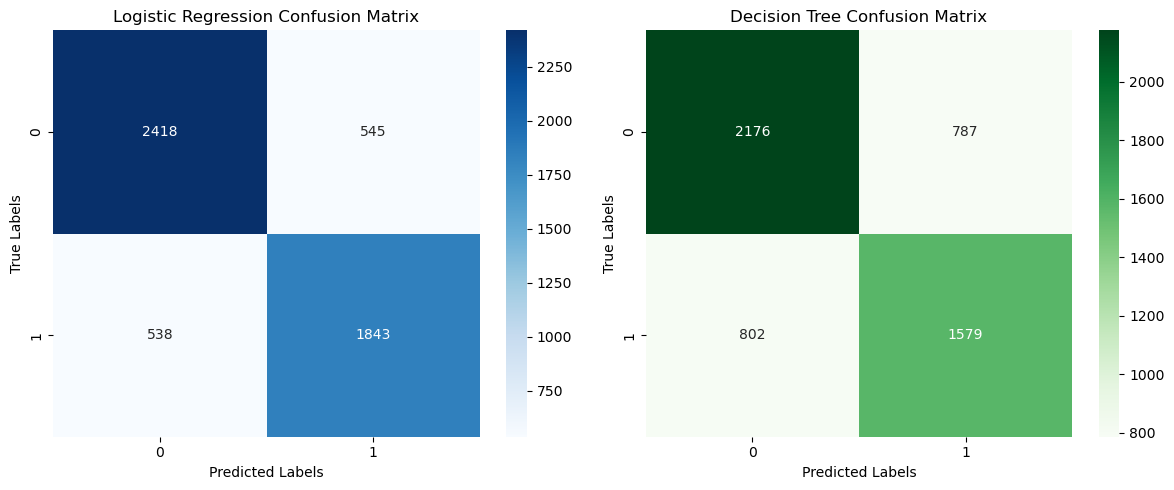

In [12]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
import re
import string
import json
import gc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the saved models and vectorizer ---

with open("logistic_model.pkl", "rb") as f:
    logistic_model = pickle.load(f)

with open("tree_model.pkl", "rb") as f:
    tree_model = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# --- Data Loading and Preprocessing (Same as training) ---

nltk.download('punkt')

try:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
except:
    stop_words = set()

def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(r"http\S+|www\S+|@\S+|#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

def extract_features(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    X_tfidf = vectorizer.transform(processed_texts).toarray()
    X_scaled = scaler.transform(X_tfidf)
    return X_scaled

custom_dataset = [
    ("Oh wow, I really love waiting in long lines... 🙄", 1),
    ("This is the best day of my life!", 0),
    ("वाह! कितना अच्छा नेटवर्क है, 10 मिनट में भी एक वीडियो नहीं खुला!", 1),
    ("आज का दिन बहुत सुंदर है।", 0),
    ("Génial! J'adore rater mon train chaque matin.", 1),
    ("C'est une belle journée ensoleillée!", 0),
    ("¡Increíble! Otra reunión sin sentido...", 1),
    ("Me encanta aprender nuevas cosas.", 0)
]

downloaded_dataset = []
dataset_path = r"C:\Users\KIIT\OneDrive\Desktop\Sentiment analysuz\Sarcasm_Headlines_Dataset.json\Sarcasm_Headlines_Dataset.json"
try:
    with open(dataset_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
        json_data = [json.loads(line) for line in lines]

    if isinstance(json_data, list):
        df = pd.DataFrame(json_data)
    elif isinstance(json_data, dict):
        df = pd.DataFrame.from_dict(json_data)
    else:
        raise ValueError("❌ JSON format is incorrect!")

    required_columns = {"headline", "is_sarcastic"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"❌ Missing required columns: {required_columns - set(df.columns)}")

    df.rename(columns={"headline": "text", "is_sarcastic": "label"}, inplace=True)
    df.dropna(inplace=True)
    df["text"] = df["text"].astype(str).apply(preprocess_text)
    df["label"] = df["label"].astype(int)
    downloaded_dataset = list(zip(df["text"], df["label"]))
    print(f"✅ Loaded {len(downloaded_dataset)} samples from downloaded dataset.")
    del df
    del json_data
    gc.collect()

except FileNotFoundError:
    print(f"❌ Error: File not found at {dataset_path}")
except json.JSONDecodeError:
    print(f"❌ Error: Invalid JSON format in {dataset_path}")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")

full_dataset = custom_dataset + downloaded_dataset
texts, labels = zip(*full_dataset)

X_tfidf = vectorizer.transform(texts).toarray()
X_scaled = scaler.transform(X_tfidf)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

# --- Model Evaluation ---

logistic_predictions = logistic_model.predict(X_test)
tree_predictions = tree_model.predict(X_test)

print("\nLogistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, logistic_predictions)}")
print(f"Precision: {precision_score(y_test, logistic_predictions)}")
print(f"Recall: {recall_score(y_test, logistic_predictions)}")
print(f"F1 Score: {f1_score(y_test, logistic_predictions)}")

cm_logistic = confusion_matrix(y_test, logistic_predictions)
print("Confusion Matrix:\n", cm_logistic)

print("\nDecision Tree Metrics:")
print(f"Accuracy: {accuracy_score(y_test, tree_predictions)}")
print(f"Precision: {precision_score(y_test, tree_predictions)}")
print(f"Recall: {recall_score(y_test, tree_predictions)}")
print(f"F1 Score: {f1_score(y_test, tree_predictions)}")

cm_tree = confusion_matrix(y_test, tree_predictions)
print("Confusion Matrix:\n", cm_tree)

# --- Plot Confusion Matrices ---

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_logistic, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.subplot(1, 2, 2)
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Greens")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.tight_layout()
plt.show()